In [157]:
import pandas as pd
import numpy as np


In [158]:
reads = pd.read_csv('centaur-data/1345_admin_reads.csv')
results = pd.read_csv('results_with_accuracy.csv')

## Exploring Reads Data

In [159]:
reads.head()

,topic_id,problem_id,user_id,read_id,labeling_state,patch,score,accuracy,contest_id,mission_id,content_id,chosen_answer,origin,origin_created_at,series,series_index,answerChoiceIds,response_submitted_at,problem_appeared_at
0,1345,5888087,55058,132610888,gold_standard,NaN,100,0.78,8011,NaN,3264386,['no'],https://centaur-customer-uploads.s3.us-east-1....,2021-07-26 21:41:47.756010+00:00,NaN,NaN,[25796611],2022-04-12 09:20:24.912000+00:00,2022-04-12 09:20:24.415999+00:00
1,1345,5888087,248277,107696869,gold_standard,NaN,100,0.76,6437,NaN,3264386,['no'],https://centaur-customer-uploads.s3.us-east-1....,2021-07-26 21:41:47.756010+00:00,NaN,NaN,[25796611],2021-12-04 15:00:58.596999+00:00,2021-12-04 15:00:56.760999+00:00
2,1345,5888088,19769,60673858,gold_standard,NaN,100,0.78,5183,NaN,3264387,['no'],https://centaur-customer-uploads.s3.us-east-1....,2021-07-26 21:41:47.824498+00:00,NaN,NaN,[25796612],2021-08-09 07:41:17.754000+00:00,2021-08-09 07:41:16.961000+00:00
3,1345,5888088,237039,99676200,gold_standard,NaN,100,0.80,6151,NaN,3264387,['no'],https://centaur-customer-uploads.s3.us-east-1....,2021-07-26 21:41:47.824498+00:00,NaN,NaN,[25796612],2021-11-01 12:05:16.948999+00:00,2021-11-01 12:05:16.076000+00:00
4,1345,5888088,280445,141519169,gold_standard,NaN,100,0.76,9076,NaN,3264387,['no'],https://centaur-customer-uploads.s3.us-east-1....,2021-07-26 21:41:47.824498+00:00,NaN,NaN,[25796612],2022-06-10 12:16:45.950000+00:00,2022-06-10 12:16:45.112000+00:00


In [160]:
reads.score.value_counts()

100    126229
0       25831
Name: score, dtype: int64

In [161]:
not_gold_standard = reads['labeling_state'] != 'gold_standard'
reads[not_gold_standard].score.value_counts()

100    25148
Name: score, dtype: int64

It appears to be the case that 'score' is a binary category. Users get 100 points for labeling correctly or 0 for not. But notice that users always get 100 points in non-gold-standard cases. Realizing this might matter for calculations later.

Below, keeping the mosty quantitative columns that we might need from the reads data, and clearing away the rest:

In [162]:
reads_quant = reads.loc[:, ['problem_id', 'user_id', 'accuracy', 'labeling_state', 'score', 'chosen_answer']]
reads_quant

,problem_id,user_id,accuracy,labeling_state,score,chosen_answer
0,5888087,55058,0.78,gold_standard,100,['no']
1,5888087,248277,0.76,gold_standard,100,['no']
2,5888088,19769,0.78,gold_standard,100,['no']
3,5888088,237039,0.80,gold_standard,100,['no']
4,5888088,280445,0.76,gold_standard,100,['no']
...,...,...,...,...,...,...
152055,5918379,19769,0.82,gold_standard,100,['yes']
152056,5918379,53129,0.78,gold_standard,100,['yes']
152057,5918379,102777,0.84,gold_standard,100,['yes']
152058,5918379,137347,0.76,gold_standard,100,['yes']


In [163]:
user_55058 = (reads['user_id'] == 55058)

In [164]:
u5508_reads = reads_quant[user_55058]
u5508_reads

,problem_id,user_id,accuracy,labeling_state,score,chosen_answer
0,5888087,55058,0.78,gold_standard,100,['no']
72,5888107,55058,0.76,gold_standard,100,['no']
81,5888111,55058,0.82,gold_standard,100,['no']
410,5888178,55058,0.78,gold_standard,100,['no']
455,5888189,55058,0.80,gold_standard,100,['no']
...,...,...,...,...,...,...
150426,5918090,55058,0.78,gold_standard,0,['yes']
150606,5918119,55058,0.80,gold_standard,100,['no']
151025,5918193,55058,0.78,gold_standard,0,['no']
151054,5918197,55058,0.82,gold_standard,100,['yes']


Can see from this example of user #55058 that user accuracy ratings change over time.

## Considering Weighted Crowd Accuracy Rating

In [165]:
results

,Case ID,Expert Yes Votes,Qualified Reads,Correct Label,Majority Label,Difficulty,Agreement,First Choice Answer,First Choice Votes,First Choice Weight,Second Choice Answer,Second Choice Votes,Second Choice Weight,Expert Accuracy,Crowd Accuracy
0,5888087,2.0,2,no,no,0.000,1.000,no,2,1.54,yes,0,0.00,0.750,1.000
1,5888088,0.0,3,no,no,0.000,1.000,no,3,2.34,yes,0,0.00,1.000,1.000
2,5888089,0.0,2,no,no,0.000,1.000,no,2,1.70,yes,0,0.00,1.000,1.000
3,5888090,0.0,1,no,no,0.000,1.000,no,1,0.82,yes,0,0.00,1.000,1.000
4,5888091,4.0,7,NaN,yes,NaN,0.571,yes,4,3.28,no,3,2.32,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26995,5918375,2.0,2,no,yes,1.000,1.000,yes,2,1.56,no,0,0.00,0.750,0.000
26996,5918376,3.0,3,no,yes,0.667,0.667,yes,2,1.56,no,1,0.76,0.625,0.333
26997,5918377,4.0,6,NaN,yes,NaN,1.000,yes,6,4.78,no,0,0.00,NaN,NaN
26998,5918378,5.0,0,yes,NaN,NaN,NaN,yes,0,0.00,no,0,0.00,0.625,NaN


Let's look only at cases that actually had qualified reads:

In [166]:
qual_reads_exist = results['Qualified Reads'] > 0
results = results[qual_reads_exist]
results

,Case ID,Expert Yes Votes,Qualified Reads,Correct Label,Majority Label,Difficulty,Agreement,First Choice Answer,First Choice Votes,First Choice Weight,Second Choice Answer,Second Choice Votes,Second Choice Weight,Expert Accuracy,Crowd Accuracy
0,5888087,2.0,2,no,no,0.000,1.000,no,2,1.54,yes,0,0.00,0.750,1.000
1,5888088,0.0,3,no,no,0.000,1.000,no,3,2.34,yes,0,0.00,1.000,1.000
2,5888089,0.0,2,no,no,0.000,1.000,no,2,1.70,yes,0,0.00,1.000,1.000
3,5888090,0.0,1,no,no,0.000,1.000,no,1,0.82,yes,0,0.00,1.000,1.000
4,5888091,4.0,7,NaN,yes,NaN,0.571,yes,4,3.28,no,3,2.32,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26994,5918374,5.0,4,yes,yes,0.000,1.000,yes,4,3.18,no,0,0.00,0.625,1.000
26995,5918375,2.0,2,no,yes,1.000,1.000,yes,2,1.56,no,0,0.00,0.750,0.000
26996,5918376,3.0,3,no,yes,0.667,0.667,yes,2,1.56,no,1,0.76,0.625,0.333
26997,5918377,4.0,6,NaN,yes,NaN,1.000,yes,6,4.78,no,0,0.00,NaN,NaN


### Calculate a Weighted Accuracy Rating

We'll calculate a weighted accuracy rating by dividing the majority weight over the total weight in each case.

Weighted Accuracy = Majority Weight / (First Choice Weight + Second Choice Weight)

This is analogous to calculating by raw number of votes, just adjusted by the user accuracy ratings instead of every vote counting equally. If a user's accuracy rating is 0.8, they are essentially considered to have cast 0.8 of a vote.

In [167]:
total_weight = results['First Choice Weight'] + results['Second Choice Weight']

In [168]:
results.insert(13, 'Total Weight', total_weight)
results

,Case ID,Expert Yes Votes,Qualified Reads,Correct Label,Majority Label,Difficulty,Agreement,First Choice Answer,First Choice Votes,First Choice Weight,Second Choice Answer,Second Choice Votes,Second Choice Weight,Total Weight,Expert Accuracy,Crowd Accuracy
0,5888087,2.0,2,no,no,0.000,1.000,no,2,1.54,yes,0,0.00,1.54,0.750,1.000
1,5888088,0.0,3,no,no,0.000,1.000,no,3,2.34,yes,0,0.00,2.34,1.000,1.000
2,5888089,0.0,2,no,no,0.000,1.000,no,2,1.70,yes,0,0.00,1.70,1.000,1.000
3,5888090,0.0,1,no,no,0.000,1.000,no,1,0.82,yes,0,0.00,0.82,1.000,1.000
4,5888091,4.0,7,NaN,yes,NaN,0.571,yes,4,3.28,no,3,2.32,5.60,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26994,5918374,5.0,4,yes,yes,0.000,1.000,yes,4,3.18,no,0,0.00,3.18,0.625,1.000
26995,5918375,2.0,2,no,yes,1.000,1.000,yes,2,1.56,no,0,0.00,1.56,0.750,0.000
26996,5918376,3.0,3,no,yes,0.667,0.667,yes,2,1.56,no,1,0.76,2.32,0.625,0.333
26997,5918377,4.0,6,NaN,yes,NaN,1.000,yes,6,4.78,no,0,0.00,4.78,NaN,NaN


In [169]:
results.loc[:, ['Case ID', 'Correct Label', 'First Choice Answer', 'First Choice Weight', 'Second Choice Answer', 
                'Second Choice Weight', 'Total Weight']]


,Case ID,Correct Label,First Choice Answer,First Choice Weight,Second Choice Answer,Second Choice Weight,Total Weight
0,5888087,no,no,1.54,yes,0.00,1.54
1,5888088,no,no,2.34,yes,0.00,2.34
2,5888089,no,no,1.70,yes,0.00,1.70
3,5888090,no,no,0.82,yes,0.00,0.82
4,5888091,NaN,yes,3.28,no,2.32,5.60
...,...,...,...,...,...,...,...
26994,5918374,yes,yes,3.18,no,0.00,3.18
26995,5918375,no,yes,1.56,no,0.00,1.56
26996,5918376,no,yes,1.56,no,0.76,2.32
26997,5918377,NaN,yes,4.78,no,0.00,4.78


In [170]:
# Apply function to results dataframe to iterate over each row.

# Return nothing if there is no Correct Label. Otherwise:
# Check what the Correct Label is, and find whether it corresponds to 'First Choice Answer' or 'Second Choice Answer'.
# Whichever is the correct Choice, divide that Choice Weight by Total Weight and return the answer.

def calc_weighted_accuracy(row):
    correct_label = row.loc['Correct Label']  
    if pd.isna(correct_label):
        return
    if correct_label == row.loc['First Choice Answer']:
        return row.loc['First Choice Weight'] / row.loc['Total Weight']
    elif correct_label == row.loc['Second Choice Answer']:
        return row.loc['Second Choice Weight'] / row.loc['Total Weight']
    
    
    

In [171]:
weighted_crowd_accuracy = results.apply(calc_weighted_accuracy, axis=1)
weighted_crowd_accuracy

0        1.000000
1        1.000000
2        1.000000
3        1.000000
4             NaN
           ...   
26994    1.000000
26995    0.000000
26996    0.327586
26997         NaN
26999    0.808081
Length: 26758, dtype: float64

In [172]:
results.insert(14, 'Weighted Crowd Accuracy', weighted_crowd_accuracy)

In [173]:
results

,Case ID,Expert Yes Votes,Qualified Reads,Correct Label,Majority Label,Difficulty,Agreement,First Choice Answer,First Choice Votes,First Choice Weight,Second Choice Answer,Second Choice Votes,Second Choice Weight,Total Weight,Weighted Crowd Accuracy,Expert Accuracy,Crowd Accuracy
0,5888087,2.0,2,no,no,0.000,1.000,no,2,1.54,yes,0,0.00,1.54,1.000000,0.750,1.000
1,5888088,0.0,3,no,no,0.000,1.000,no,3,2.34,yes,0,0.00,2.34,1.000000,1.000,1.000
2,5888089,0.0,2,no,no,0.000,1.000,no,2,1.70,yes,0,0.00,1.70,1.000000,1.000,1.000
3,5888090,0.0,1,no,no,0.000,1.000,no,1,0.82,yes,0,0.00,0.82,1.000000,1.000,1.000
4,5888091,4.0,7,NaN,yes,NaN,0.571,yes,4,3.28,no,3,2.32,5.60,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26994,5918374,5.0,4,yes,yes,0.000,1.000,yes,4,3.18,no,0,0.00,3.18,1.000000,0.625,1.000
26995,5918375,2.0,2,no,yes,1.000,1.000,yes,2,1.56,no,0,0.00,1.56,0.000000,0.750,0.000
26996,5918376,3.0,3,no,yes,0.667,0.667,yes,2,1.56,no,1,0.76,2.32,0.327586,0.625,0.333
26997,5918377,4.0,6,NaN,yes,NaN,1.000,yes,6,4.78,no,0,0.00,4.78,NaN,NaN,NaN


In [174]:
results.loc[:, ['Case ID', 'First Choice Weight', 'Total Weight', 'Weighted Crowd Accuracy', 'Expert Accuracy']]

,Case ID,First Choice Weight,Total Weight,Weighted Crowd Accuracy,Expert Accuracy
0,5888087,1.54,1.54,1.000000,0.750
1,5888088,2.34,2.34,1.000000,1.000
2,5888089,1.70,1.70,1.000000,1.000
3,5888090,0.82,0.82,1.000000,1.000
4,5888091,3.28,5.60,NaN,NaN
...,...,...,...,...,...
26994,5918374,3.18,3.18,1.000000,0.625
26995,5918375,1.56,1.56,0.000000,0.750
26996,5918376,1.56,2.32,0.327586,0.625
26997,5918377,4.78,4.78,NaN,NaN


## Considering Weighted Accuracy in Gold Standard Cases

At this point, we can begin to make comparisons between expert accuracy and the weighted crowd accuracy. 

First, we'll limit the data we're looking at to just gold standard cases. Then, we'll calculate the difference between expert accuracy and weighted crowd accurary ratings. And finally, we'll look at what that difference can tell us about what percentage of the time the expert accuracy was greater, or the crowd weighted accuracy was greater.

In [175]:
correct_label_exists = pd.notna(results['Correct Label'])
gold_standard_results = results[correct_label_exists]
gold_standard_results

,Case ID,Expert Yes Votes,Qualified Reads,Correct Label,Majority Label,Difficulty,Agreement,First Choice Answer,First Choice Votes,First Choice Weight,Second Choice Answer,Second Choice Votes,Second Choice Weight,Total Weight,Weighted Crowd Accuracy,Expert Accuracy,Crowd Accuracy
0,5888087,2.0,2,no,no,0.000,1.000,no,2,1.54,yes,0,0.00,1.54,1.000000,0.750,1.000
1,5888088,0.0,3,no,no,0.000,1.000,no,3,2.34,yes,0,0.00,2.34,1.000000,1.000,1.000
2,5888089,0.0,2,no,no,0.000,1.000,no,2,1.70,yes,0,0.00,1.70,1.000000,1.000,1.000
3,5888090,0.0,1,no,no,0.000,1.000,no,1,0.82,yes,0,0.00,0.82,1.000000,1.000,1.000
5,5888092,0.0,4,no,no,0.000,1.000,no,4,3.30,yes,0,0.00,3.30,1.000000,1.000,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26993,5918373,5.0,1,yes,yes,0.000,1.000,yes,1,0.80,no,0,0.00,0.80,1.000000,0.625,1.000
26994,5918374,5.0,4,yes,yes,0.000,1.000,yes,4,3.18,no,0,0.00,3.18,1.000000,0.625,1.000
26995,5918375,2.0,2,no,yes,1.000,1.000,yes,2,1.56,no,0,0.00,1.56,0.000000,0.750,0.000
26996,5918376,3.0,3,no,yes,0.667,0.667,yes,2,1.56,no,1,0.76,2.32,0.327586,0.625,0.333


In [176]:
set(gold_standard_results['Correct Label'])

{'no', 'yes'}

In [177]:
difference_weighted = gold_standard_results.loc[:, ['Case ID', 'Expert Accuracy', 'Weighted Crowd Accuracy']]
difference_weighted

,Case ID,Expert Accuracy,Weighted Crowd Accuracy
0,5888087,0.750,1.000000
1,5888088,1.000,1.000000
2,5888089,1.000,1.000000
3,5888090,1.000,1.000000
5,5888092,1.000,1.000000
...,...,...,...
26993,5918373,0.625,1.000000
26994,5918374,0.625,1.000000
26995,5918375,0.750,0.000000
26996,5918376,0.625,0.327586


In [178]:
difference_weighted['Difference'] = gold_standard_results['Expert Accuracy'] - gold_standard_results['Weighted Crowd Accuracy']
difference_weighted

,Case ID,Expert Accuracy,Weighted Crowd Accuracy,Difference
0,5888087,0.750,1.000000,-0.250000
1,5888088,1.000,1.000000,0.000000
2,5888089,1.000,1.000000,0.000000
3,5888090,1.000,1.000000,0.000000
5,5888092,1.000,1.000000,0.000000
...,...,...,...,...
26993,5918373,0.625,1.000000,-0.375000
26994,5918374,0.625,1.000000,-0.375000
26995,5918375,0.750,0.000000,0.750000
26996,5918376,0.625,0.327586,0.297414


### Comparing Accuracy Ratings for All Gold Standard Cases

In the histograms that will appear in the next few sections:

Positive values mean the expert accuracy rating was higher than the crowd's.

Negative values mean the crowd weighted accuracy rating was higher than the experts.

0 means the accuracy ratings were the same.

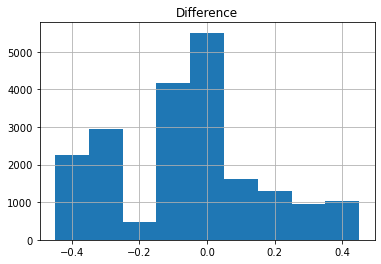

In [179]:
bins=np.arange(-0.45, 0.46, 0.1)
difference_weighted.hist('Difference', bins=bins);

In [180]:
same_accuracy_rate = np.count_nonzero(difference_weighted['Difference'] == 0) / len(difference_weighted)
same_accuracy_rate

0.18166512332687937

In [181]:
experts_higher_rate = np.count_nonzero(difference_weighted['Difference'] > 0) / len(difference_weighted)
experts_higher_rate

0.37940904116508123

In [182]:
weighted_crowd_higher_rate = np.count_nonzero(difference_weighted['Difference'] < 0) / len(difference_weighted)
weighted_crowd_higher_rate

0.4389258355080394

In [183]:
same_accuracy_rate + experts_higher_rate + weighted_crowd_higher_rate

1.0

In [184]:
same_accuracy_rate + weighted_crowd_higher_rate

0.6205909588349188

### Numbers of interest that arise out of this comparison:

<b>Equal accuracy rate:</b> 18.2% of the time both the weighted crowd and the experts had the same accuracy rate.

<b>Expert accuracy rate higher:</b> 37.9% of cases have the expert accuracy rate higher than the weighted crowd accuracy.

<b>Crowd accuracy rate higher:</b> 43.9% of cases have the weighted crowd with the higher accuracy rate over the experts.

In these numbers overall, the weighted crowd accuracy rate is <i>at least as good</i> as the expert accuracy rate 62.1% of the time.

<h2>Comparing Cases In More Detail</h2>

<h3>Expert Vote Unanimous</h3>

How does the comparison with weighted crowd accuracy look specifically on cases where the experts were unanimous?

In [185]:
experts_unanimous = difference_weighted[difference_weighted['Expert Accuracy'] == 1]
experts_unanimous

,Case ID,Expert Accuracy,Weighted Crowd Accuracy,Difference
1,5888088,1.0,1.000000,0.000000
2,5888089,1.0,1.000000,0.000000
3,5888090,1.0,1.000000,0.000000
5,5888092,1.0,1.000000,0.000000
6,5888093,1.0,1.000000,0.000000
...,...,...,...,...
26832,5918212,1.0,1.000000,0.000000
26850,5918230,1.0,1.000000,0.000000
26902,5918282,1.0,1.000000,0.000000
26911,5918291,1.0,0.516129,0.483871


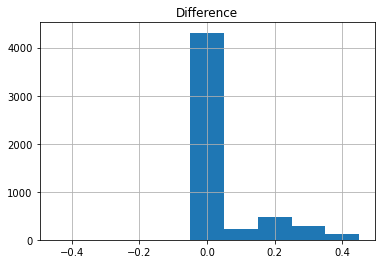

In [186]:
experts_unanimous.hist('Difference', bins=bins);

In [187]:
np.count_nonzero(experts_unanimous['Weighted Crowd Accuracy'] == 1) / len(experts_unanimous)

0.7246596066565809

In [188]:
np.count_nonzero(experts_unanimous['Weighted Crowd Accuracy'] > 0.5) / len(experts_unanimous)

0.9246932257522272

In cases where the experts were unanimous with their labeling, by definition their accuracy is 100%. We can look at the difference of accuracy to get a sense of how closely the weighted crowd accuracy followed along. 

The weighted crowd vote favored the correct label 92.5% of the time when the experts were unanimous. And 72.5% of the time, the weighted crowd vote was also unanimous and correct.

In [189]:
experts_unanimous[experts_unanimous['Weighted Crowd Accuracy'] <= 0.5]

,Case ID,Expert Accuracy,Weighted Crowd Accuracy,Difference
361,5888490,1.0,0.490683,0.509317
505,5888639,1.0,0.248408,0.751592
677,5891840,1.0,0.262195,0.737805
679,5891851,1.0,0.000000,1.000000
690,5891911,1.0,0.500000,0.500000
...,...,...,...,...
25786,5917166,1.0,0.251613,0.748387
25814,5917194,1.0,0.000000,1.000000
25891,5917271,1.0,0.403941,0.596059
26020,5917400,1.0,0.000000,1.000000


In [190]:
min(experts_unanimous['Weighted Crowd Accuracy'])

0.0

<h3>Slim Majority in Expert Votes</h3>

What about more difficult cases where the experts were as close as possible to a tie? In terms of our expert accuracy rate, this kind of case has the value 5/8.

In [191]:
experts_5_votes = difference_weighted[difference_weighted['Expert Accuracy'] == 5/8]
experts_5_votes

,Case ID,Expert Accuracy,Weighted Crowd Accuracy,Difference
178,5888290,0.625,1.000000,-0.375000
371,5888500,0.625,0.858657,-0.233657
388,5888517,0.625,0.254658,0.370342
662,5891621,0.625,0.000000,0.625000
672,5891813,0.625,0.855615,-0.230615
...,...,...,...,...
26989,5918369,0.625,0.672269,-0.047269
26993,5918373,0.625,1.000000,-0.375000
26994,5918374,0.625,1.000000,-0.375000
26996,5918376,0.625,0.327586,0.297414


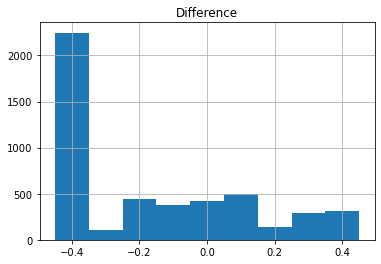

In [192]:
experts_5_votes.hist('Difference', bins=bins);

In [193]:
np.count_nonzero(experts_5_votes['Difference'] < 0) / len(experts_5_votes)

0.5756656555443208

In these slim expert majority cases, the weighted crowd accuracy outperformed the experts, being higher than the expert accuracy 57.6% of the time.

<h2>Expert Vote Tied, Correct Label Undefined</h2>

By the way we've defined a correct label, we simply don't have one in the difficult cases where the expert vote came out tied.

But what does the crowd weighted vote suggest in these cases? Is it also more or less split, or does it more strongly suggest a direction?

In [194]:
no_correct_label = pd.isna(results['Correct Label'])
experts_split_vote = results[no_correct_label]
experts_split_vote

,Case ID,Expert Yes Votes,Qualified Reads,Correct Label,Majority Label,Difficulty,Agreement,First Choice Answer,First Choice Votes,First Choice Weight,Second Choice Answer,Second Choice Votes,Second Choice Weight,Total Weight,Weighted Crowd Accuracy,Expert Accuracy,Crowd Accuracy
4,5888091,4.0,7,NaN,yes,NaN,0.571,yes,4,3.28,no,3,2.32,5.60,NaN,NaN,NaN
603,5888782,4.0,5,NaN,no,NaN,1.000,no,5,3.94,yes,0,0.00,3.94,NaN,NaN,NaN
674,5891822,4.0,5,NaN,yes,NaN,0.800,yes,4,3.10,no,1,0.76,3.86,NaN,NaN,NaN
702,5891960,4.0,7,NaN,no,NaN,1.000,no,7,5.53,yes,0,0.00,5.53,NaN,NaN,NaN
710,5891979,4.0,8,NaN,no,NaN,0.625,no,5,3.92,yes,3,2.38,6.30,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26978,5918358,4.0,13,NaN,yes,NaN,0.769,yes,10,7.84,no,3,2.36,10.20,NaN,NaN,NaN
26980,5918360,4.0,5,NaN,yes,NaN,1.000,yes,5,3.92,no,0,0.00,3.92,NaN,NaN,NaN
26983,5918363,4.0,8,NaN,yes,NaN,1.000,yes,8,6.26,no,0,0.00,6.26,NaN,NaN,NaN
26986,5918366,4.0,10,NaN,yes,NaN,0.900,yes,9,7.18,no,1,0.80,7.98,NaN,NaN,NaN


In [195]:
experts_split_vote.loc[:, ['Case ID', 'First Choice Weight', 'Second Choice Weight', 'Total Weight']]

,Case ID,First Choice Weight,Second Choice Weight,Total Weight
4,5888091,3.28,2.32,5.60
603,5888782,3.94,0.00,3.94
674,5891822,3.10,0.76,3.86
702,5891960,5.53,0.00,5.53
710,5891979,3.92,2.38,6.30
...,...,...,...,...
26978,5918358,7.84,2.36,10.20
26980,5918360,3.92,0.00,3.92
26983,5918363,6.26,0.00,6.26
26986,5918366,7.18,0.80,7.98


We will calculate how unified the weighted vote was by dividing the majority vote weight by the total weight.

In [196]:
'''
For each row in the experts-split-vote dataframe: 

Find which of First Choice Weight or Second Choice Weight is larger, then divide that larger weight value 
by Total Weight, and return the result. If the weights are the same, it doesn't matter which one is divided 
into Total Weight, so let that case be folded into the first check.
'''

def calc_majority_weight(row):
    weight_1 = row.loc['First Choice Weight']
    weight_2 = row.loc['Second Choice Weight']
    total_weight = row.loc['Total Weight']
    if weight_1 >= weight_2:
        return weight_1 / total_weight
    elif weight_2 > weight_1:
        return weight_2 / total_weight

In [197]:
majority_weight = experts_split_vote.apply(calc_majority_weight, axis=1)
majority_weight

4        0.585714
603      1.000000
674      0.803109
702      1.000000
710      0.622222
           ...   
26978    0.768627
26980    1.000000
26983    1.000000
26986    0.899749
26997    1.000000
Length: 3000, dtype: float64

In [198]:
experts_split_vote.insert(13, 'Majority Weight', majority_weight)

In [199]:
experts_split_vote.loc[:, ['Case ID', 'First Choice Weight', 'Second Choice Weight', 'Total Weight', 'Majority Weight']]

,Case ID,First Choice Weight,Second Choice Weight,Total Weight,Majority Weight
4,5888091,3.28,2.32,5.60,0.585714
603,5888782,3.94,0.00,3.94,1.000000
674,5891822,3.10,0.76,3.86,0.803109
702,5891960,5.53,0.00,5.53,1.000000
710,5891979,3.92,2.38,6.30,0.622222
...,...,...,...,...,...
26978,5918358,7.84,2.36,10.20,0.768627
26980,5918360,3.92,0.00,3.92,1.000000
26983,5918363,6.26,0.00,6.26,1.000000
26986,5918366,7.18,0.80,7.98,0.899749


In [200]:
np.count_nonzero(experts_split_vote['Majority Weight'] == 0.5)

10

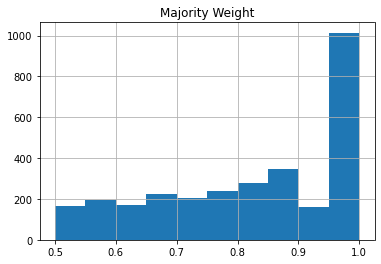

In [201]:
experts_split_vote.hist('Majority Weight');

In [202]:
np.count_nonzero(experts_split_vote['Majority Weight'] == 1) / len(experts_split_vote)

0.338

In [203]:
np.count_nonzero(experts_split_vote['Majority Weight'] >= 0.75) / len(experts_split_vote)

0.6796666666666666

In 33.8% of these cases, the crowd vote was unanimous.

In 68.0% of these cases, the crowd had a large majority weighted vote, leaning at least 75% in one direction.

## Comparing Weighted Vote to Plain Vote Count

<i>Insert numbers here from last week's analysis. The point that will come out of the comparison is that they are not very much different.</i>

## Alternative Aggregation of Crowd Vote: Exponential Weighting

A desirable method of further increasing the accuracy of crowd would be one that could give much greater favor to higher-accuracy labelers over lower-accuracy ones. 

If we obtain a new weight by squaring the accuracy ratings of our users, the weights would disproportionately favor users with high accuracy ratings. This effect can be seen in the ranges shown below. Numbers between 0 and 1 will be reduced when squared, but with the effect that as the numbers get smaller, the factors by which they get reduced become increasingly greater.



In [204]:
nums = np.arange(0.1,1.1,0.1)
nums

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [205]:
nums_squared = np.arange(0.1,1.1,0.1)**2
nums_squared

array([0.01, 0.04, 0.09, 0.16, 0.25, 0.36, 0.49, 0.64, 0.81, 1.  ])

In [206]:
nums / nums_squared

array([10.        ,  5.        ,  3.33333333,  2.5       ,  2.        ,
        1.66666667,  1.42857143,  1.25      ,  1.11111111,  1.        ])

We'll need to apply this idea to the accuracy scores in the reads table, and then go on to calculate a new first choice and second choice weighting for each problem.

In [207]:
reads_quant

,problem_id,user_id,accuracy,labeling_state,score,chosen_answer
0,5888087,55058,0.78,gold_standard,100,['no']
1,5888087,248277,0.76,gold_standard,100,['no']
2,5888088,19769,0.78,gold_standard,100,['no']
3,5888088,237039,0.80,gold_standard,100,['no']
4,5888088,280445,0.76,gold_standard,100,['no']
...,...,...,...,...,...,...
152055,5918379,19769,0.82,gold_standard,100,['yes']
152056,5918379,53129,0.78,gold_standard,100,['yes']
152057,5918379,102777,0.84,gold_standard,100,['yes']
152058,5918379,137347,0.76,gold_standard,100,['yes']


In [208]:
reads_quant.accuracy.value_counts().sort_index()

0.75     1673
0.76    40424
0.77     1061
0.78    33347
0.79      609
0.80    26145
0.81      668
0.82    18796
0.83      391
0.84    12437
0.85      359
0.86     7848
0.87      113
0.88     4368
0.89       82
0.90     2292
0.91       42
0.92      901
0.93       17
0.94      262
0.96      140
0.97        5
0.98       69
1.00       11
Name: accuracy, dtype: int64

Noting that the reads table already strongly favors high accuracy ratings by excluding any users whose accuracy rating is less than 0.75.

In [209]:
reads_quant.insert(3, 'squared_accuracy', reads_quant['accuracy']**2 )

In [210]:
reads_quant.squared_accuracy.value_counts().sort_index()

0.5625     1673
0.5776    40424
0.5929     1061
0.6084    33347
0.6241      609
0.6400    26145
0.6561      668
0.6724    18796
0.6889      391
0.7056    12437
0.7225      359
0.7396     7848
0.7569      113
0.7744     4368
0.7921       82
0.8100     2292
0.8281       42
0.8464      901
0.8649       17
0.8836      262
0.9216      140
0.9409        5
0.9604       69
1.0000       11
Name: squared_accuracy, dtype: int64

In [211]:
reads_quant

,problem_id,user_id,accuracy,squared_accuracy,labeling_state,score,chosen_answer
0,5888087,55058,0.78,0.6084,gold_standard,100,['no']
1,5888087,248277,0.76,0.5776,gold_standard,100,['no']
2,5888088,19769,0.78,0.6084,gold_standard,100,['no']
3,5888088,237039,0.80,0.6400,gold_standard,100,['no']
4,5888088,280445,0.76,0.5776,gold_standard,100,['no']
...,...,...,...,...,...,...,...
152055,5918379,19769,0.82,0.6724,gold_standard,100,['yes']
152056,5918379,53129,0.78,0.6084,gold_standard,100,['yes']
152057,5918379,102777,0.84,0.7056,gold_standard,100,['yes']
152058,5918379,137347,0.76,0.5776,gold_standard,100,['yes']


In [215]:
reads_quant.loc[:, ['problem_id', 'user_id', 'squared_accuracy']]

,problem_id,user_id,squared_accuracy
0,5888087,55058,0.6084
1,5888087,248277,0.5776
2,5888088,19769,0.6084
3,5888088,237039,0.6400
4,5888088,280445,0.5776
...,...,...,...
152055,5918379,19769,0.6724
152056,5918379,53129,0.6084
152057,5918379,102777,0.7056
152058,5918379,137347,0.5776


In [212]:
results

,Case ID,Expert Yes Votes,Qualified Reads,Correct Label,Majority Label,Difficulty,Agreement,First Choice Answer,First Choice Votes,First Choice Weight,Second Choice Answer,Second Choice Votes,Second Choice Weight,Total Weight,Weighted Crowd Accuracy,Expert Accuracy,Crowd Accuracy
0,5888087,2.0,2,no,no,0.000,1.000,no,2,1.54,yes,0,0.00,1.54,1.000000,0.750,1.000
1,5888088,0.0,3,no,no,0.000,1.000,no,3,2.34,yes,0,0.00,2.34,1.000000,1.000,1.000
2,5888089,0.0,2,no,no,0.000,1.000,no,2,1.70,yes,0,0.00,1.70,1.000000,1.000,1.000
3,5888090,0.0,1,no,no,0.000,1.000,no,1,0.82,yes,0,0.00,0.82,1.000000,1.000,1.000
4,5888091,4.0,7,NaN,yes,NaN,0.571,yes,4,3.28,no,3,2.32,5.60,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26994,5918374,5.0,4,yes,yes,0.000,1.000,yes,4,3.18,no,0,0.00,3.18,1.000000,0.625,1.000
26995,5918375,2.0,2,no,yes,1.000,1.000,yes,2,1.56,no,0,0.00,1.56,0.000000,0.750,0.000
26996,5918376,3.0,3,no,yes,0.667,0.667,yes,2,1.56,no,1,0.76,2.32,0.327586,0.625,0.333
26997,5918377,4.0,6,NaN,yes,NaN,1.000,yes,6,4.78,no,0,0.00,4.78,NaN,NaN,NaN


In [213]:
'''
Ideally, what we want to return here is a pair of values: a new first choice weight and a new second choice 
weight for each unique problem_id.

What info is needed to do this?

from reads:
problem_id
squared_accuracy
chosen_answer

from results:
Case ID
First Choice Answer
Second Choice Answer
'''

def calc_squared_weighting_by_problem(row_in_reads):
    
    

IndentationError: expected an indented block (674939617.py, line 20)